In [1]:
!nvidia-smi

Sat May 31 03:30:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installing Data
## Intel Image Classification Dataset Overview
The Intel Image Classification dataset, available on Kaggle, is a collection of approximately 25,000 images categorized into six distinct natural scene classes:
- buildings
- forest
- glacier
- mountain
- sea
- street

Each image in the dataset is an RGB image with a resolution of 150x150 pixels.

The dataset is organized into two main splits. The training set contains 14,034 images, with roughly 2,339 images per class. The test set comprises 3,000 images, with about 500 images for each class.



In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/puneet6060/intel-image-classification"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yuvrajbalagoni
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


100%|██████████| 346M/346M [00:01<00:00, 237MB/s]


# Preprocessing & visualizing data

In [4]:
import os
from pathlib import Path
os.listdir()

['.config', 'intel-image-classification', 'sample_data']

In [5]:
data_path = os.path.join(os.getcwd(), "intel-image-classification")
data_path

'/content/intel-image-classification'

In [6]:
train_dir = Path(os.path.join(data_path, "seg_train", "seg_train"))
test_dir = Path(os.path.join(data_path, "seg_test", "seg_test"))

class_labels = os.listdir(train_dir)
class_labels.sort()
class_labels, len(class_labels)

(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], 6)

In [7]:
for label in class_labels:
  print(f"{label} : {len(os.listdir(os.path.join(train_dir, label)))}")

buildings : 2191
forest : 2271
glacier : 2404
mountain : 2512
sea : 2274
street : 2382


In [8]:
for label in class_labels:
  print(f"{label} : {len(os.listdir(os.path.join(test_dir, label)))}")

buildings : 437
forest : 474
glacier : 553
mountain : 525
sea : 510
street : 501


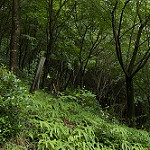

In [9]:
from PIL import Image
test_image = Path(os.path.join(os.path.join(train_dir, class_labels[1]), "10007.jpg"))
img = Image.open(test_image)
img

In [10]:
for label in class_labels:
  total_len = len(os.listdir(os.path.join(train_dir, label))) + len(os.listdir(os.path.join(test_dir, label)))
  print(len(os.listdir(os.path.join(train_dir, label))) * 100/total_len, len(os.listdir(os.path.join(test_dir, label))) * 100/total_len )

83.37138508371385 16.62861491628615
82.73224043715847 17.26775956284153
81.29861345958741 18.70138654041258
82.71320381955877 17.286796180441225
81.68103448275862 18.31896551724138
82.62226847034339 17.377731529656607


In [11]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [12]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [13]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform= transform,
                                  target_transform= None)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform= transform)

In [14]:
len(train_data), len(test_data)

(14034, 3000)

In [15]:
train_data

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /content/intel-image-classification/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [16]:
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 64,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 64,
                             shuffle = False)
len(train_dataloader), len(test_dataloader)

(220, 47)

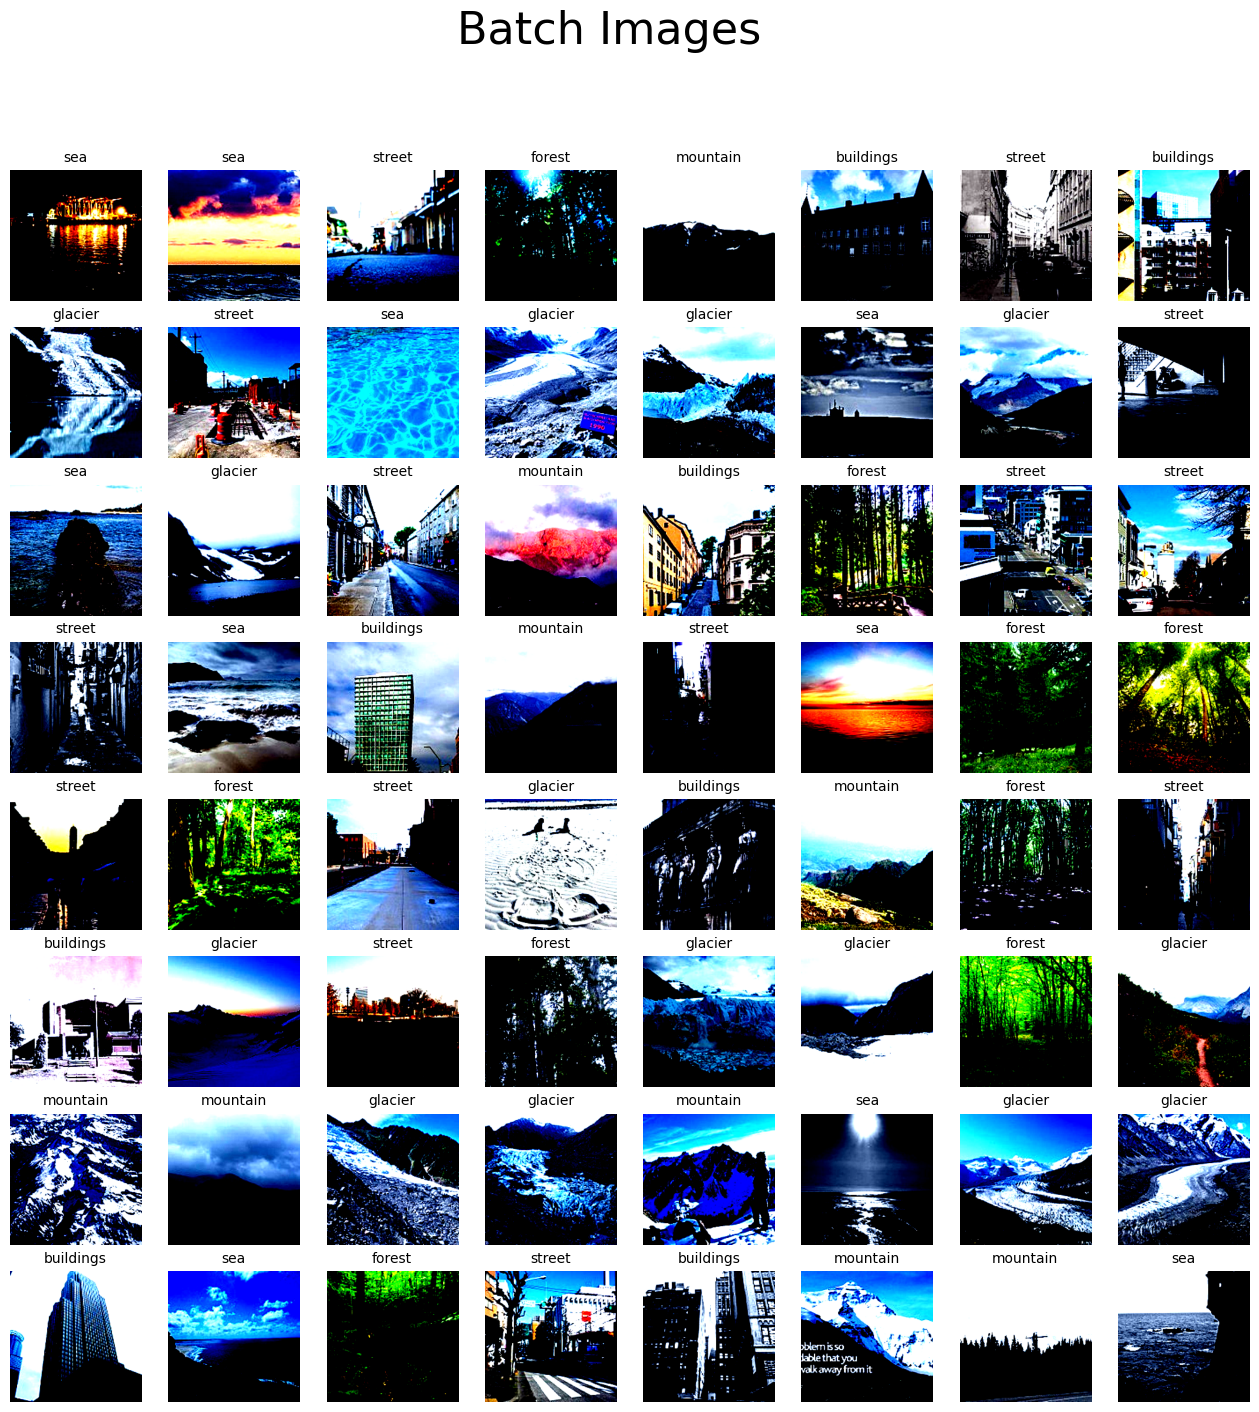

In [17]:
fig = plt.figure(figsize=(16,16))
fig.suptitle("Batch Images", fontsize= 32)
rows, cols = 8, 8
for batch_idx, (img,label) in enumerate(train_dataloader):
  if batch_idx == 0:
    for i in range(1, rows*cols + 1):
      fig.add_subplot(rows, cols, i)
      plt.imshow(img[i-1].permute(1,2,0))
      plt.title(class_labels[label[i-1]], fontsize=10)
      plt.axis(False);
    break

# Creating Teacher Model

In [18]:
Tmodel_weights = torchvision.models.ResNet50_Weights.DEFAULT
Tmodel_weights

ResNet50_Weights.IMAGENET1K_V2

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
Tmodel = torchvision.models.resnet50(weights= Tmodel_weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [21]:
!pip install torchinfo

In [22]:
from torchinfo import summary
summary(model= Tmodel,
        input_size= (16,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [16, 3, 224, 224]         [16, 1000]                --                        True
├─Conv2d: 1-1                            [16, 3, 224, 224]         [16, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        [16, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [16, 64, 112, 112]        [16, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [16, 64, 112, 112]        [16, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [16, 64, 56, 56]          [16, 256, 56, 56]         --                        True
│    └─Bottleneck: 2-1                   [16, 64, 56, 56]          [16, 256, 56, 56]         --                        True
│    │ 

In [23]:
Tmodel.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [24]:
for parameter in Tmodel.parameters():
  parameter.requires_grad = False

Tmodel.fc = nn.Sequential(
    nn.Linear(in_features=2048,
              out_features=6,
              bias=True)
)

summary(model= Tmodel,
        input_size= (64,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [64, 3, 224, 224]         [64, 6]                   --                        Partial
├─Conv2d: 1-1                            [64, 3, 224, 224]         [64, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        [64, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [64, 64, 112, 112]        [64, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [64, 64, 112, 112]        [64, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [64, 64, 56, 56]          [64, 256, 56, 56]         --                        False
│    └─Bottleneck: 2-1                   [64, 64, 56, 56]          [64, 256, 56, 56]         --                        False


In [25]:
optimizer = torch.optim.Adam(params= Tmodel.parameters(),
                             lr= 0.001)
loss_fn = nn.CrossEntropyLoss()

In [26]:
from tqdm.auto import tqdm

epochs = 15

results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
           }
for epoch in tqdm(range(epochs)):
  Tmodel.train()
  train_loss, train_acc = 0,0
  y_train_predicted = []
  y_train_actual = []
  for batch, (X,y) in enumerate(train_dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = Tmodel(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    y_train_predicted.extend(y_pred_class.cpu().numpy())
    y_train_actual.extend(y.cpu().numpy())

  train_loss = train_loss/len(train_dataloader)
  train_acc = train_acc/len(train_dataloader)

  Tmodel.eval()
  test_loss, test_acc = 0, 0
  y_test_actual = []
  y_test_predicted = []

  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
      X,y = X.to(device), y.to(device)
      test_pred = Tmodel(X)
      test_loss += loss_fn(test_pred, y).item()

      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      test_acc += (test_pred_class == y).sum().item()/len(test_pred)

      y_test_predicted.extend(test_pred_class.cpu().numpy())
      y_test_actual.extend(y.cpu().numpy())

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  print(f"Epoch {epoch + 1}/{epochs}: train loss: {train_loss:.4f} |\ntrain accuracy: {train_acc:.4f} |\ntest loss: {test_loss:.4f} |\ntest accuracy: {test_acc:.4f}")
print("training Completed")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15: train loss: 0.5116 |
train accuracy: 0.8500 |
test loss: 0.3187 |
test accuracy: 0.8973
Epoch 2/15: train loss: 0.2850 |
train accuracy: 0.9062 |
test loss: 0.2781 |
test accuracy: 0.8999
Epoch 3/15: train loss: 0.2479 |
train accuracy: 0.9166 |
test loss: 0.2473 |
test accuracy: 0.9104
Epoch 4/15: train loss: 0.2208 |
train accuracy: 0.9244 |
test loss: 0.2416 |
test accuracy: 0.9098
Epoch 5/15: train loss: 0.2084 |
train accuracy: 0.9282 |
test loss: 0.2318 |
test accuracy: 0.9148
Epoch 6/15: train loss: 0.1967 |
train accuracy: 0.9308 |
test loss: 0.2309 |
test accuracy: 0.9135
Epoch 7/15: train loss: 0.1863 |
train accuracy: 0.9357 |
test loss: 0.2255 |
test accuracy: 0.9167
Epoch 8/15: train loss: 0.1813 |
train accuracy: 0.9381 |
test loss: 0.2246 |
test accuracy: 0.9171
Epoch 9/15: train loss: 0.1715 |
train accuracy: 0.9415 |
test loss: 0.2204 |
test accuracy: 0.9181
Epoch 10/15: train loss: 0.1662 |
train accuracy: 0.9423 |
test loss: 0.2244 |
test accuracy: 0.9177

In [27]:
len(y_train_actual), len(y_train_predicted)

(14034, 14034)

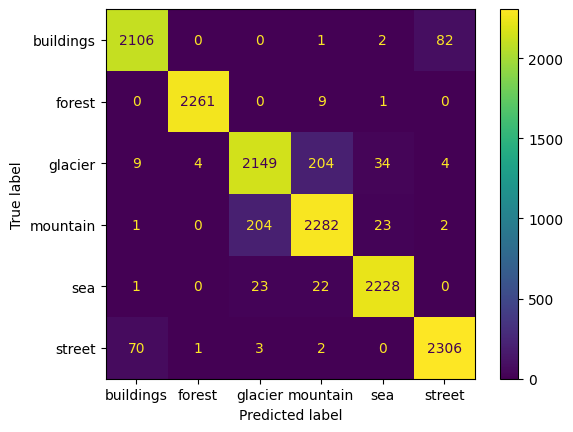

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_train_actual, y_train_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot();

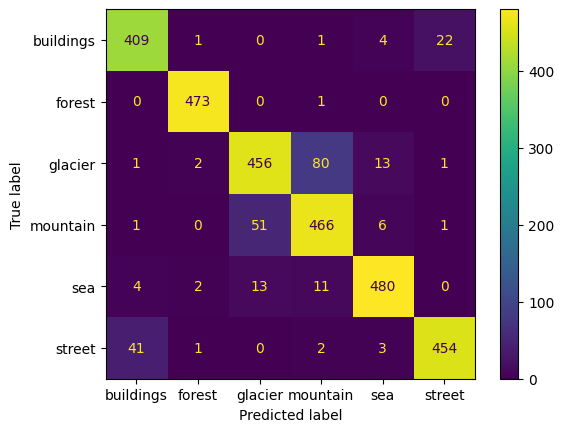

In [29]:
cm = confusion_matrix(y_test_actual, y_test_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot();

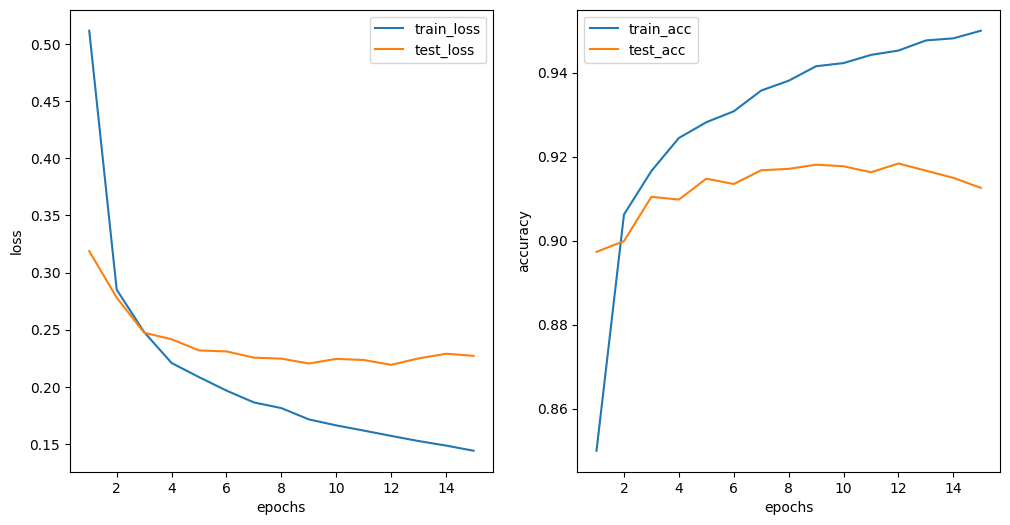

In [30]:
num = 15
epochs = list(range(1, num+1))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, results["train_loss"], label="train_loss")
plt.plot(epochs, results["test_loss"], label="test_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, results["train_acc"], label="train_acc")
plt.plot(epochs, results["test_acc"], label="test_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Training student model without knowledge distillation
using mobilenetv3-small as student model.
10 times smaller than the teacher model.

In [50]:
Smodel = torchvision.models.mobilenet_v3_small(pretrained=False).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [51]:
summary(model=Smodel,
        input_size= (64,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV3                                        [64, 3, 224, 224]         [64, 1000]                --                        True
├─Sequential: 1-1                                  [64, 3, 224, 224]         [64, 576, 7, 7]           --                        True
│    └─Conv2dNormActivation: 2-1                   [64, 3, 224, 224]         [64, 16, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                            [64, 3, 224, 224]         [64, 16, 112, 112]        432                       True
│    │    └─BatchNorm2d: 3-2                       [64, 16, 112, 112]        [64, 16, 112, 112]        32                        True
│    │    └─Hardswish: 3-3                         [64, 16, 112, 112]        [64, 16, 112, 112]        --                        --
│    └─InvertedResidual: 2-2                       [64, 16,

In [43]:
Smodel.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [45]:
# for parameter in Smodel.parameters():
#   parameter.requires_grad = False

Smodel.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=6, bias=True)
).to(device)

In [46]:
summary(model=Smodel,
        input_size= (16,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV3                                        [16, 3, 224, 224]         [16, 6]                   --                        Partial
├─Sequential: 1-1                                  [16, 3, 224, 224]         [16, 576, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                   [16, 3, 224, 224]         [16, 16, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                            [16, 3, 224, 224]         [16, 16, 112, 112]        (432)                     False
│    │    └─BatchNorm2d: 3-2                       [16, 16, 112, 112]        [16, 16, 112, 112]        (32)                      False
│    │    └─Hardswish: 3-3                         [16, 16, 112, 112]        [16, 16, 112, 112]        --                        --
│    └─InvertedResidual: 2-2                       [

# training without knowledge distillation

In [52]:
soptimizer = torch.optim.Adam(params= Smodel.parameters(),
                             lr= 0.001)
loss_fn = nn.CrossEntropyLoss()

In [53]:
from tqdm.auto import tqdm

epochs = 15

s_results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
           }
for epoch in tqdm(range(epochs)):
  Smodel.train()
  strain_loss, strain_acc = 0,0
  sy_train_predicted = []
  sy_train_actual = []
  for batch, (X,y) in enumerate(train_dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = Smodel(X)
    loss = loss_fn(y_pred, y)
    strain_loss += loss.item()

    soptimizer.zero_grad()
    loss.backward()
    soptimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    strain_acc += (y_pred_class == y).sum().item()/len(y_pred)

    sy_train_predicted.extend(y_pred_class.cpu().numpy())
    sy_train_actual.extend(y.cpu().numpy())

  strain_loss = strain_loss/len(train_dataloader)
  strain_acc = strain_acc/len(train_dataloader)

  Smodel.eval()
  stest_loss, stest_acc = 0, 0
  sy_test_actual = []
  sy_test_predicted = []

  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
      X,y = X.to(device), y.to(device)
      test_pred = Smodel(X)
      stest_loss += loss_fn(test_pred, y).item()

      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      stest_acc += (test_pred_class == y).sum().item()/len(test_pred)

      sy_test_predicted.extend(test_pred_class.cpu().numpy())
      sy_test_actual.extend(y.cpu().numpy())

    stest_loss /= len(test_dataloader)
    stest_acc /= len(test_dataloader)

  s_results["train_loss"].append(strain_loss.item() if isinstance(strain_loss, torch.Tensor) else strain_loss)
  s_results["train_acc"].append(strain_acc.item() if isinstance(strain_acc, torch.Tensor) else strain_acc)
  s_results["test_loss"].append(stest_loss.item() if isinstance(stest_loss, torch.Tensor) else stest_loss)
  s_results["test_acc"].append(stest_acc.item() if isinstance(stest_acc, torch.Tensor) else stest_acc)

  print(f"Epoch {epoch + 1}/{epochs}: train loss: {strain_loss:.4f} |\ntrain accuracy: {strain_acc:.4f} |\ntest loss: {stest_loss:.4f} |\ntest accuracy: {stest_acc:.4f}")
print("training Completed")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15: train loss: 1.1464 |
train accuracy: 0.5989 |
test loss: 2.0513 |
test accuracy: 0.1695
Epoch 2/15: train loss: 0.6129 |
train accuracy: 0.7737 |
test loss: 2.2895 |
test accuracy: 0.1868
Epoch 3/15: train loss: 0.5237 |
train accuracy: 0.8125 |
test loss: 0.5980 |
test accuracy: 0.7790
Epoch 4/15: train loss: 0.4467 |
train accuracy: 0.8434 |
test loss: 0.6048 |
test accuracy: 0.7734
Epoch 5/15: train loss: 0.3906 |
train accuracy: 0.8624 |
test loss: 0.7066 |
test accuracy: 0.7898
Epoch 6/15: train loss: 0.3683 |
train accuracy: 0.8683 |
test loss: 0.6521 |
test accuracy: 0.7831
Epoch 7/15: train loss: 0.3314 |
train accuracy: 0.8822 |
test loss: 0.5142 |
test accuracy: 0.8330
Epoch 8/15: train loss: 0.2936 |
train accuracy: 0.8962 |
test loss: 0.5647 |
test accuracy: 0.8251
Epoch 9/15: train loss: 0.2727 |
train accuracy: 0.9038 |
test loss: 0.6921 |
test accuracy: 0.8109
Epoch 10/15: train loss: 0.2488 |
train accuracy: 0.9113 |
test loss: 0.6778 |
test accuracy: 0.8068

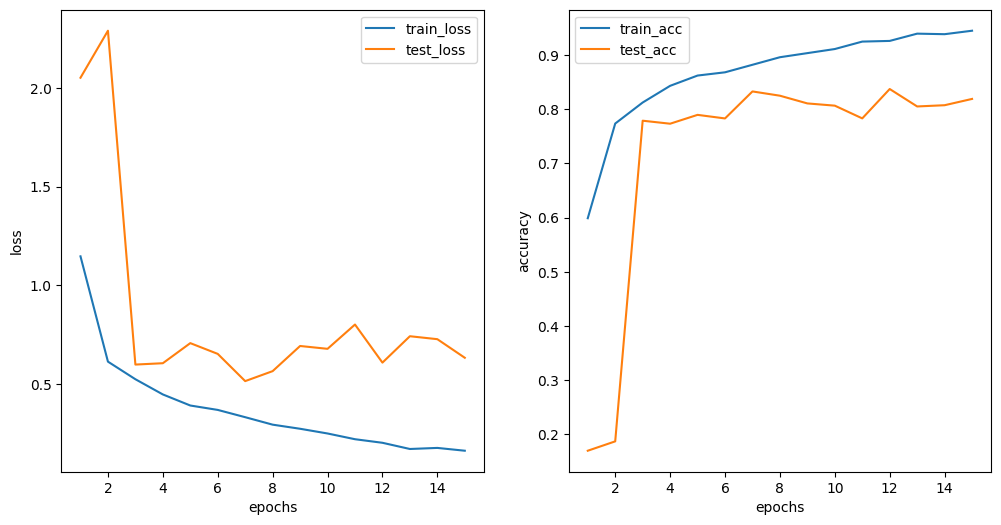

In [54]:
num = 15
epochs = list(range(1, num+1))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, s_results["train_loss"], label="train_loss")
plt.plot(epochs, s_results["test_loss"], label="test_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, s_results["train_acc"], label="train_acc")
plt.plot(epochs, s_results["test_acc"], label="test_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Compare btw teacher & non distilled student

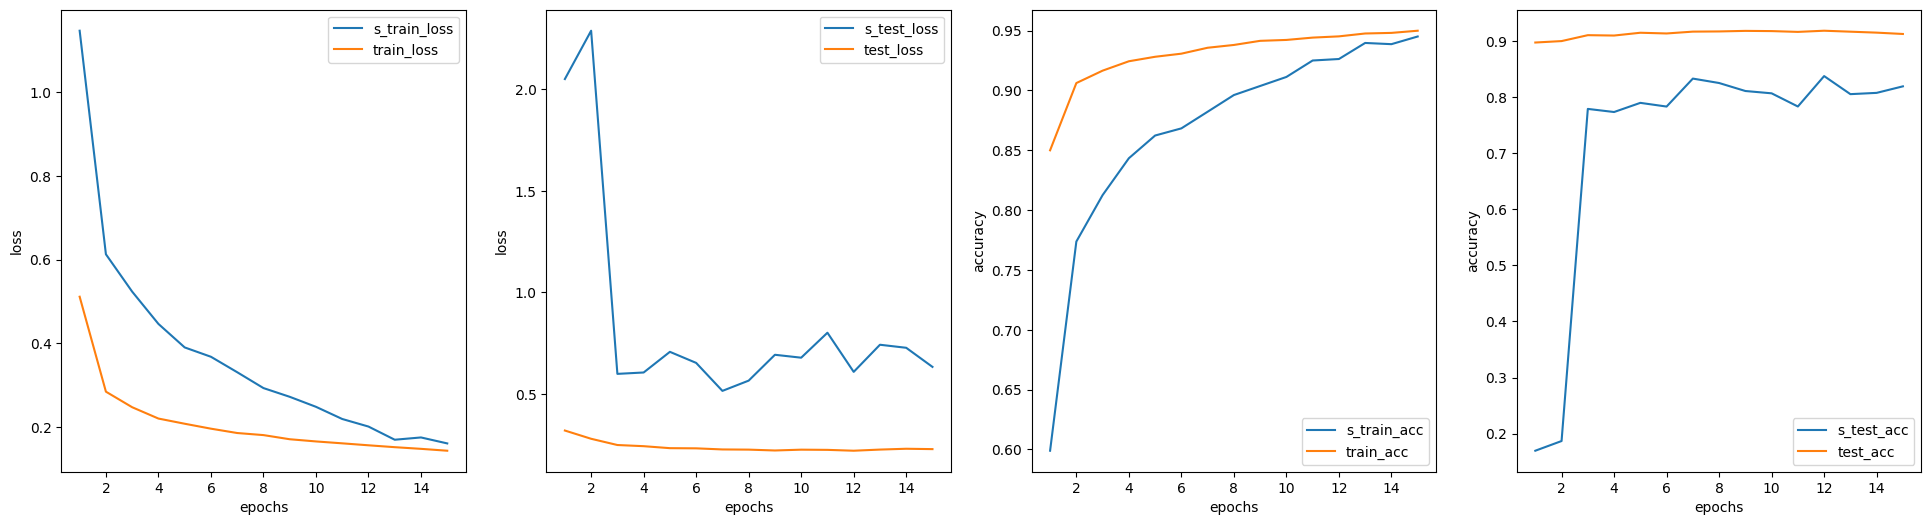

In [55]:
num = 15
epochs = list(range(1, num+1))

plt.figure(figsize=(24,6))
plt.subplot(1,4,1)
plt.plot(epochs, s_results["train_loss"], label="s_train_loss")
plt.plot(epochs, results["train_loss"], label="train_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,4,2)
plt.plot(epochs, s_results["test_loss"], label="s_test_loss")
plt.plot(epochs, results["test_loss"], label="test_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,4,3)
plt.plot(epochs, s_results["train_acc"], label="s_train_acc")
plt.plot(epochs, results["train_acc"], label="train_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.subplot(1,4,4)
plt.plot(epochs, s_results["test_acc"], label="s_test_acc")
plt.plot(epochs, results["test_acc"], label="test_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### we can see that student overfitted.

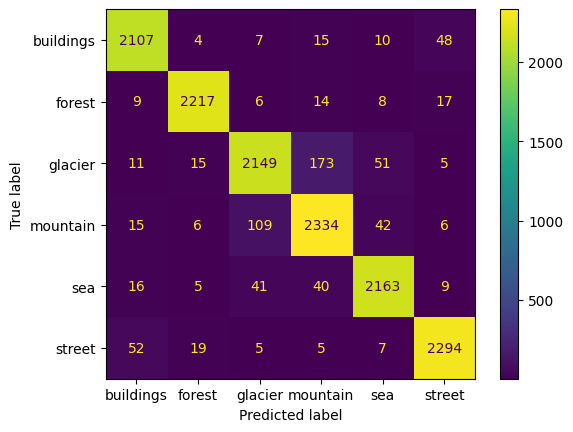

In [77]:
cm = confusion_matrix(sy_train_actual, sy_train_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot();

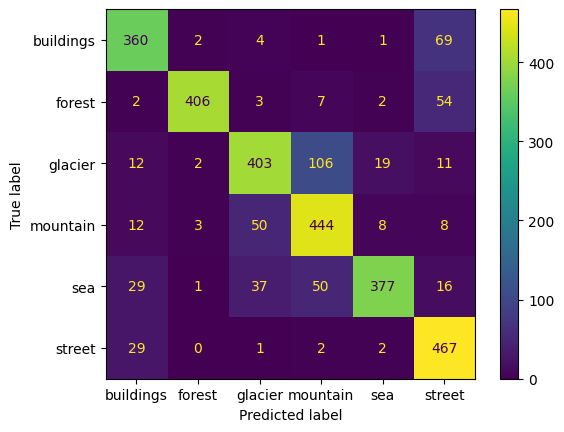

In [78]:
cm = confusion_matrix(sy_test_actual, sy_test_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot();

# With Knowledge Distillation

In [60]:
import torch.nn.functional as F

class KL_Divergence_Loss(nn.Module):
    def __init__(self, temperature=1, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha

    def forward(self, y_pred, teacher_logits, y_true):
        # Process teacher logits with temperature
        teacher_soft = F.softmax(teacher_logits / self.temperature, dim=1).detach()

        # Process student logits with temperature
        student_log_soft = F.log_softmax(y_pred / self.temperature, dim=1)

        # Compute KL divergence (scaled by T²)
        kl_loss = F.kl_div(
            input=student_log_soft,
            target=teacher_soft,
            reduction='batchmean'
        ) * (self.temperature ** 2)

        # Standard cross-entropy (no temperature)
        ce_loss = F.cross_entropy(y_pred, y_true)

        # Combine losses
        total_loss = self.alpha * ce_loss + (1 - self.alpha) * kl_loss
        return total_loss


In [61]:
kdmodel = torchvision.models.mobilenet_v3_small(pretrained=False).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [66]:
# for parameter in kdmodel.parameters():
#   parameter.requires_grad = False

kdmodel.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=6, bias=True)
).to(device)

In [67]:
summary(model=kdmodel,
        input_size= (16,3,224,224),
        col_names= ["input_size", "output_size","num_params", "trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
MobileNetV3                                        [16, 3, 224, 224]         [16, 6]                   --                        True
├─Sequential: 1-1                                  [16, 3, 224, 224]         [16, 576, 7, 7]           --                        True
│    └─Conv2dNormActivation: 2-1                   [16, 3, 224, 224]         [16, 16, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                            [16, 3, 224, 224]         [16, 16, 112, 112]        432                       True
│    │    └─BatchNorm2d: 3-2                       [16, 16, 112, 112]        [16, 16, 112, 112]        32                        True
│    │    └─Hardswish: 3-3                         [16, 16, 112, 112]        [16, 16, 112, 112]        --                        --
│    └─InvertedResidual: 2-2                       [16, 16,

In [68]:
kdoptimizer = torch.optim.Adam(params= kdmodel.parameters(),
                             lr= 0.001)
loss_fn = KL_Divergence_Loss(temperature=3, alpha=0.25)

In [69]:
from tqdm.auto import tqdm

epochs = 15

kd_results = {"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []
           }
for epoch in tqdm(range(epochs)):
  kdmodel.train()
  Tmodel.eval()
  kdtrain_loss, kdtrain_acc = 0,0
  kdy_train_predicted = []
  kdy_train_actual = []
  for batch, (X,y) in enumerate(train_dataloader):
    X,y = X.to(device), y.to(device)
    with torch.no_grad():
      soft_labels = Tmodel(X)
    y_pred = kdmodel(X)
    loss = loss_fn(y_pred, soft_labels, y)
    kdtrain_loss += loss.item()

    kdoptimizer.zero_grad()
    loss.backward()
    kdoptimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    kdtrain_acc += (y_pred_class == y).sum().item()/len(y_pred)

    kdy_train_predicted.extend(y_pred_class.cpu().numpy())
    kdy_train_actual.extend(y.cpu().numpy())

  kdtrain_loss = kdtrain_loss/len(train_dataloader)
  kdtrain_acc = kdtrain_acc/len(train_dataloader)

  kdmodel.eval()
  Tmodel.eval()
  kdtest_loss, kdtest_acc = 0, 0
  kdy_test_actual = []
  kdy_test_predicted = []

  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
      X,y = X.to(device), y.to(device)
      test_soft_labels = Tmodel(X)
      test_pred = kdmodel(X)
      kdtest_loss += loss_fn(test_pred, test_soft_labels, y).item()

      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      kdtest_acc += (test_pred_class == y).sum().item()/len(test_pred)

      kdy_test_predicted.extend(test_pred_class.cpu().numpy())
      kdy_test_actual.extend(y.cpu().numpy())

    kdtest_loss /= len(test_dataloader)
    kdtest_acc /= len(test_dataloader)

  kd_results["train_loss"].append(kdtrain_loss.item() if isinstance(kdtrain_loss, torch.Tensor) else kdtrain_loss)
  kd_results["train_acc"].append(kdtrain_acc.item() if isinstance(kdtrain_acc, torch.Tensor) else kdtrain_acc)
  kd_results["test_loss"].append(kdtest_loss.item() if isinstance(kdtest_loss, torch.Tensor) else kdtest_loss)
  kd_results["test_acc"].append(kdtest_acc.item() if isinstance(kdtest_acc, torch.Tensor) else kdtest_acc)

  print(f"Epoch {epoch + 1}/{epochs}: train loss: {kdtrain_loss:.4f} |\ntrain accuracy: {kdtrain_acc:.4f} |\ntest loss: {kdtest_loss:.4f} |\ntest accuracy: {kdtest_acc:.4f}")
print("training Completed")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15: train loss: 2.8433 |
train accuracy: 0.6482 |
test loss: 7.2478 |
test accuracy: 0.1752
Epoch 2/15: train loss: 1.6955 |
train accuracy: 0.7898 |
test loss: 8.4135 |
test accuracy: 0.2277
Epoch 3/15: train loss: 1.3972 |
train accuracy: 0.8184 |
test loss: 2.0213 |
test accuracy: 0.7724
Epoch 4/15: train loss: 1.2068 |
train accuracy: 0.8458 |
test loss: 1.3825 |
test accuracy: 0.8227
Epoch 5/15: train loss: 1.0661 |
train accuracy: 0.8622 |
test loss: 1.8122 |
test accuracy: 0.7857
Epoch 6/15: train loss: 0.9709 |
train accuracy: 0.8738 |
test loss: 1.5333 |
test accuracy: 0.7954
Epoch 7/15: train loss: 0.9138 |
train accuracy: 0.8803 |
test loss: 2.0728 |
test accuracy: 0.7571
Epoch 8/15: train loss: 0.8410 |
train accuracy: 0.8912 |
test loss: 1.6751 |
test accuracy: 0.8090
Epoch 9/15: train loss: 0.7847 |
train accuracy: 0.8979 |
test loss: 1.4783 |
test accuracy: 0.8237
Epoch 10/15: train loss: 0.7637 |
train accuracy: 0.9032 |
test loss: 1.3504 |
test accuracy: 0.8381

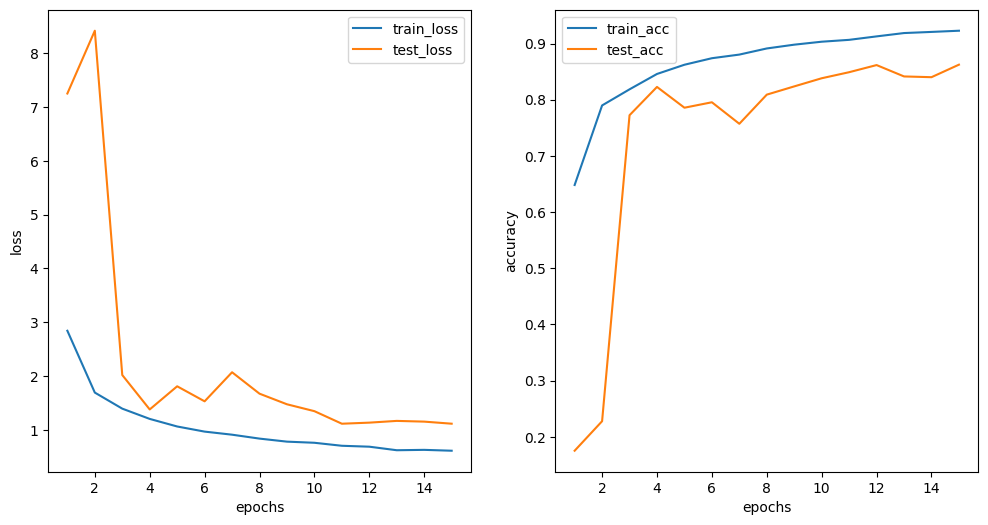

In [70]:
num = 15
epochs = list(range(1, num+1))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, kd_results["train_loss"], label="train_loss")
plt.plot(epochs, kd_results["test_loss"], label="test_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, kd_results["train_acc"], label="train_acc")
plt.plot(epochs, kd_results["test_acc"], label="test_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

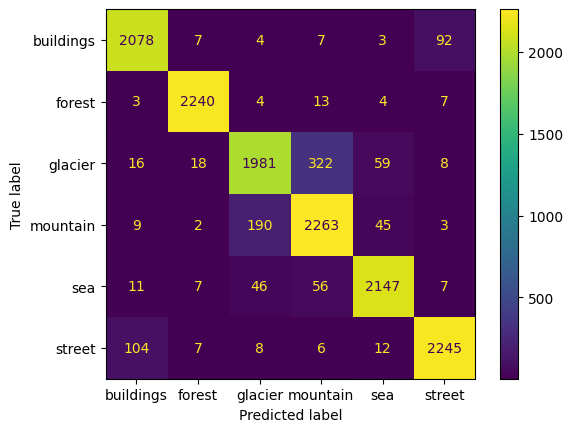

In [79]:
cm = confusion_matrix(kdy_train_actual, kdy_train_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot();

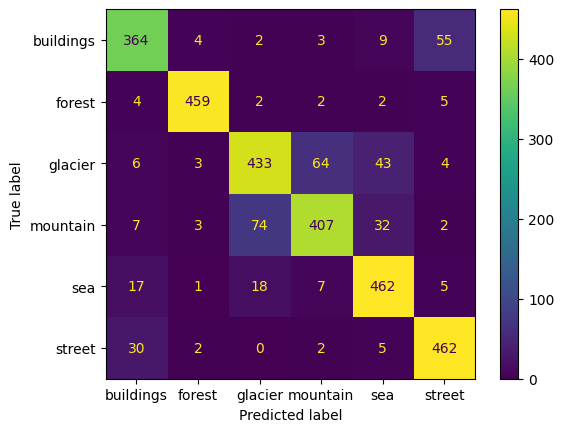

In [80]:
cm = confusion_matrix(kdy_test_actual, kdy_test_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot();

<Figure size 2400x600 with 0 Axes>

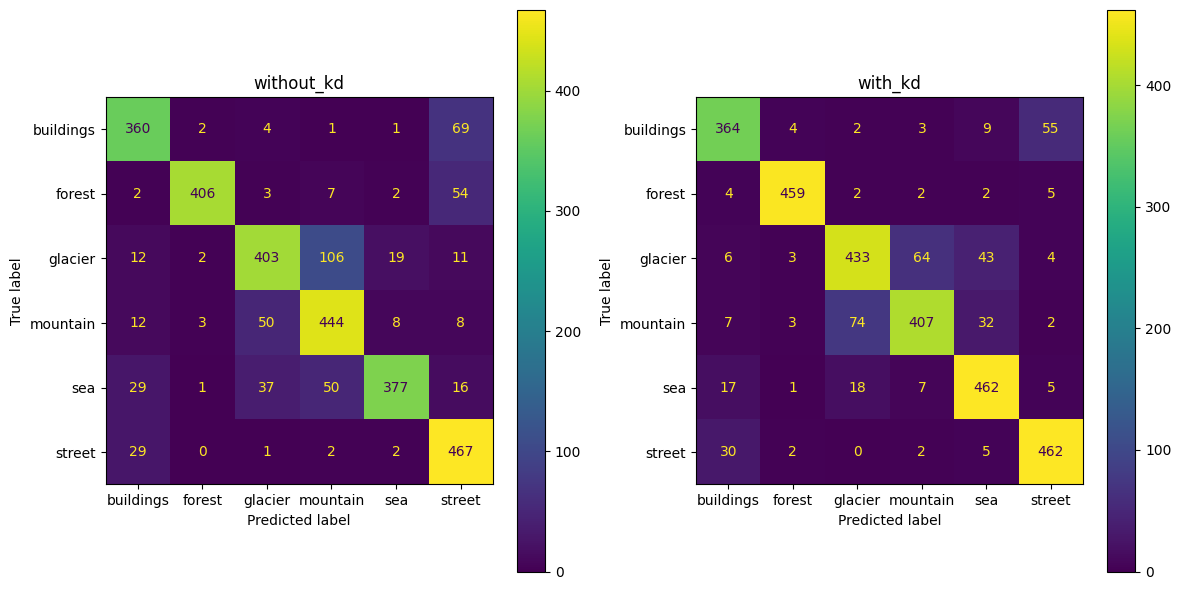

In [96]:
plt.figure(figsize=(24,6))
fig, axes = plt.subplots(1,2, figsize=(12,6))

cm = confusion_matrix(sy_test_actual, sy_test_predicted)
disp1 = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp1.plot(ax=axes[0])
axes[0].set_title("without_kd")

cm = confusion_matrix(kdy_test_actual, kdy_test_predicted)
disp2 = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp2.plot(ax=axes[1])
axes[1].set_title("with_kd")

plt.tight_layout()
plt.show()

# Comparison
- we can see that the model has improved its performance drastically after knowledge distillation on classes:
  - forest
  - glacier
  - sea
- It performed a bit poor on mountain only.

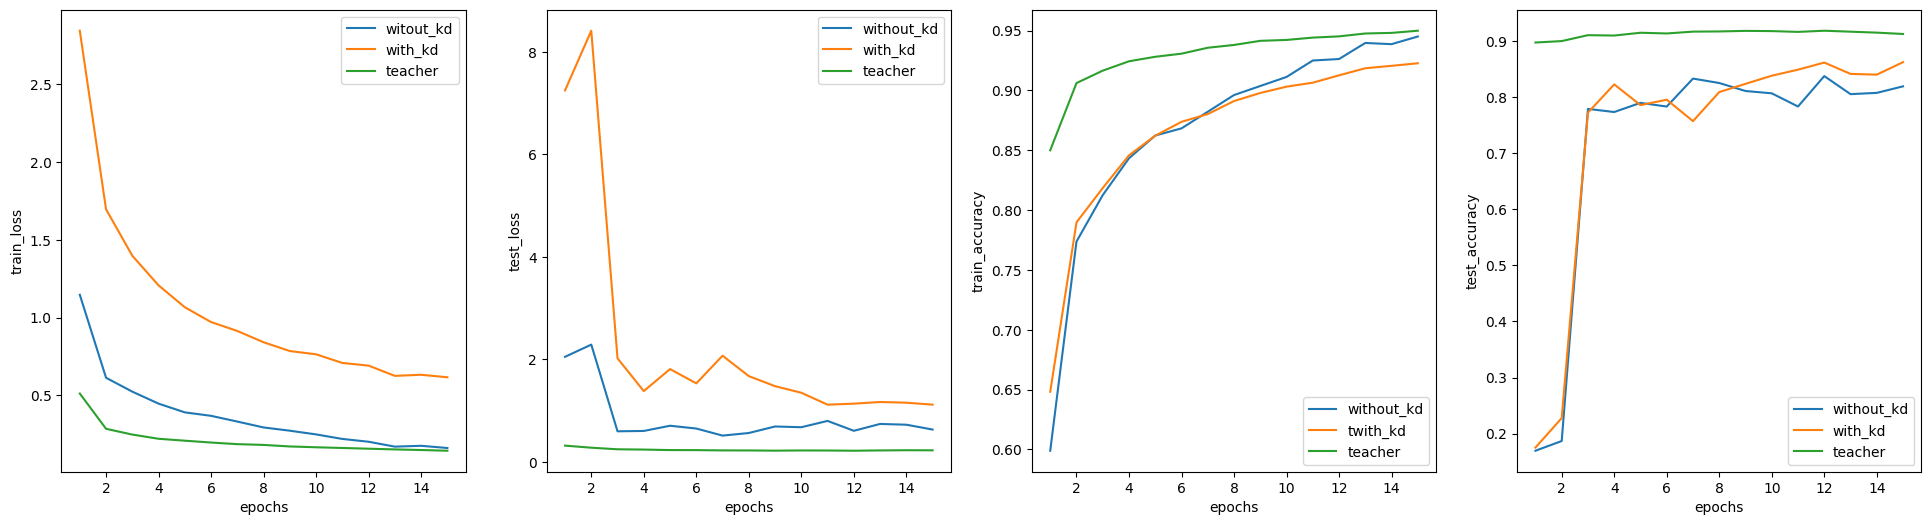

In [76]:
num = 15
epochs = list(range(1, num+1))

plt.figure(figsize=(24,6))
plt.subplot(1,4,1)
plt.plot(epochs, s_results["train_loss"], label="witout_kd")
plt.plot(epochs, kd_results["train_loss"], label="with_kd")
plt.plot(epochs, results["train_loss"], label="teacher")
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.legend()

plt.subplot(1,4,2)
plt.plot(epochs, s_results["test_loss"], label="without_kd")
plt.plot(epochs, kd_results["test_loss"], label="with_kd")
plt.plot(epochs, results["test_loss"], label="teacher")
plt.xlabel("epochs")
plt.ylabel("test_loss")
plt.legend()

plt.subplot(1,4,3)
plt.plot(epochs, s_results["train_acc"], label="without_kd")
plt.plot(epochs, kd_results["train_acc"], label="twith_kd")
plt.plot(epochs, results["train_acc"], label="teacher")
plt.xlabel("epochs")
plt.ylabel("train_accuracy")
plt.legend()

plt.subplot(1,4,4)
plt.plot(epochs, s_results["test_acc"], label="without_kd")
plt.plot(epochs, kd_results["test_acc"], label="with_kd")
plt.plot(epochs, results["test_acc"], label="teacher")
plt.xlabel("epochs")
plt.ylabel("test_accuracy")
plt.legend()
plt.show()

# Conclusion:
we can see that the test accuracy went from ```81.92%``` to ```86.23%```.
The model without Knowledge distillation was overfitting to the dataset but as we can see that with Knowledge distillation the overfitting was reduced drastically.
The losses of knowledge distillation is large because of the The T² scaling factor significantly amplifies the loss magnitude.